# Waveform Selection

## Time Domain Signal
To begin with lets generate an example waveform to send.We will assume that the signal is being transmitted continually by the source. The signal should therefore be continious so there is no step in the input stream between packets. Initially the waveform shape of choice will be a chirp as a result of its good autocorrelation properties.

In [1]:
import numpy as np
from scipy import signal

# Parameters
fs = 30.72e6
T = 1/fs
L = 6144

# Generate Time Vector
t = np.linspace(0, L*T, L+1)

# Generate Signal - 10kHz to 1MHz Chirp
f0 = 10e3
f1 = 1e6
t1 = L*T
x = signal.chirp(t, f0, t1, f1, method='linear', phi=0)

Now lets plot the time domain signal:

<IPython.core.display.Javascript object>


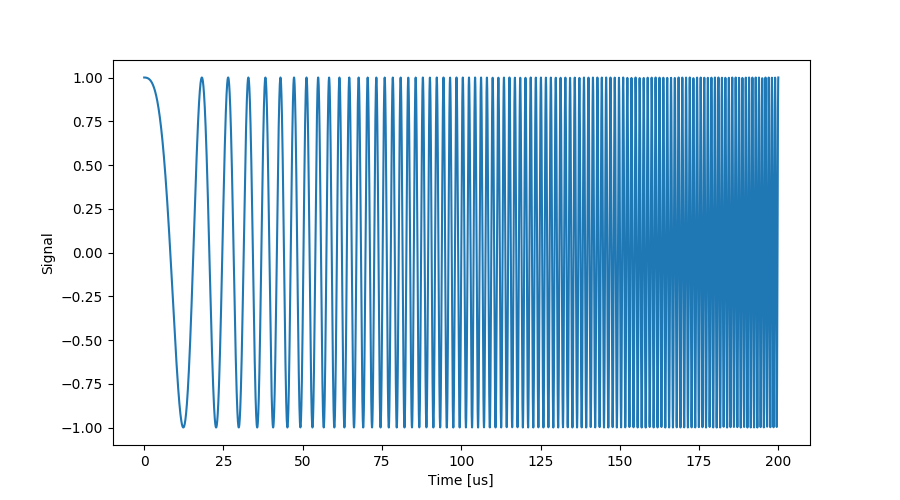

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot x(t) with t in microseconds
plt.plot(t*1e6,x)

# Label Axis
plt.xlabel('Time [us]')
plt.ylabel('Signal')
plt.show()

Lets confirm that L has been chosen correctly to ensure x(t) is continious in time:

In [3]:
x[0] == x[L]

True

## Signal Bandwidth
Next let us look at the frequency spectrum of the time domain signal x(t).

<IPython.core.display.Javascript object>


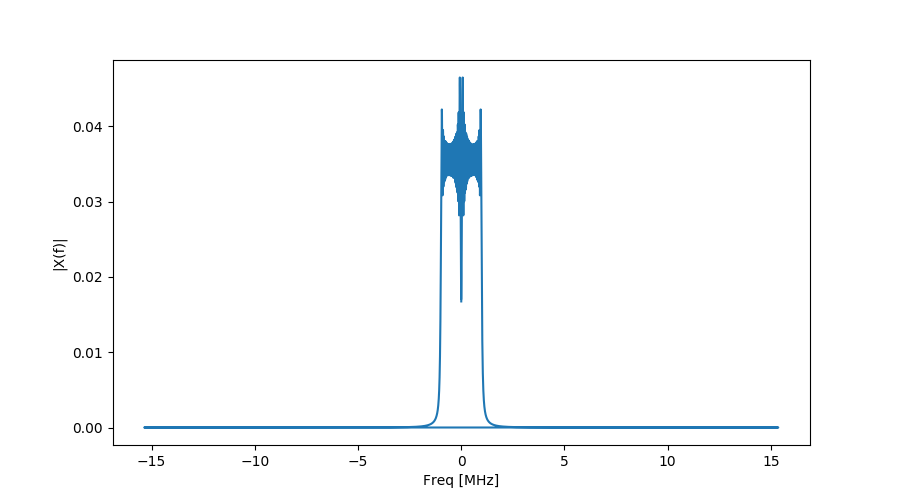

In [4]:
# Compute FFT & Frequency Bins
spectrum = np.fft.fft(x)
freq = np.fft.fftfreq(x.size, T)

# Plot Normalised |X(f)|
fig = plt.figure(figsize=(9, 5))
plt.plot(freq/1e6, np.abs(spectrum)/L)

# Label Axis
plt.xlabel('Freq [MHz]')
plt.ylabel('|X(f)|')
plt.show()

The spectrum is symmetric because the signal is real valued. The bandwidth of the signal is well below the Nyquist frequency set by our sampling rate of 30.72MS/s. Lets plot a segment of the positive frequency spectrum and determine the bandwidth of the signal.

<IPython.core.display.Javascript object>


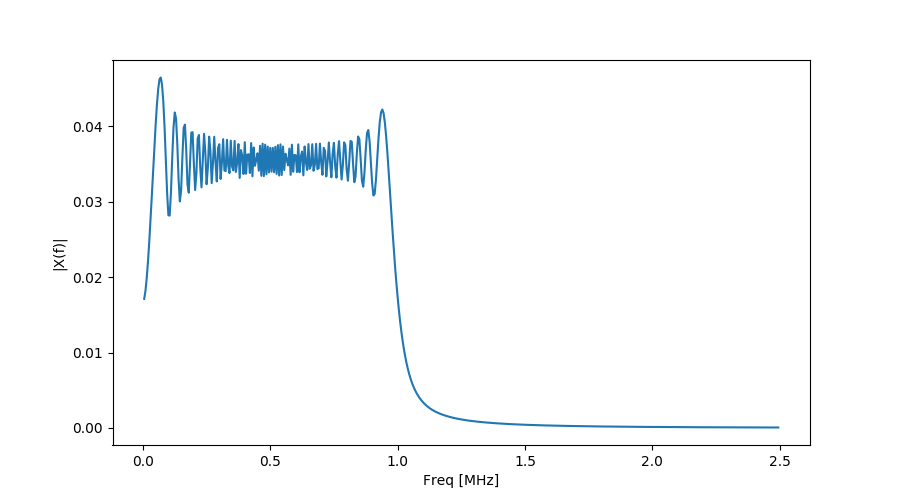

In [5]:
# Extract ~ 0 to 2.5MHz
zoom_spec = spectrum[1:500]
zoom_freq = freq[1:500]

# Plot Normalised |X(f)|
fig = plt.figure(figsize=(9, 5))
plt.plot(zoom_freq/1e6, np.abs(zoom_spec)/L)

# Label Axis
plt.xlabel('Freq [MHz]')
plt.ylabel('|X(f)|')
plt.show()

Unsurprisingly the bandwidth of the signal is set by the the upper instantaneous frequency of the chirp, which in this case is equal to 1 Mhz.



# Transmission

## Geometry
With the baseband signal selected lets model sending the data. In order to take account of the attenuation introduced by the FSPL we must first know the distance between recievers and transmitters. For simplicity we will initially consider a 2D problem.

<IPython.core.display.Javascript object>


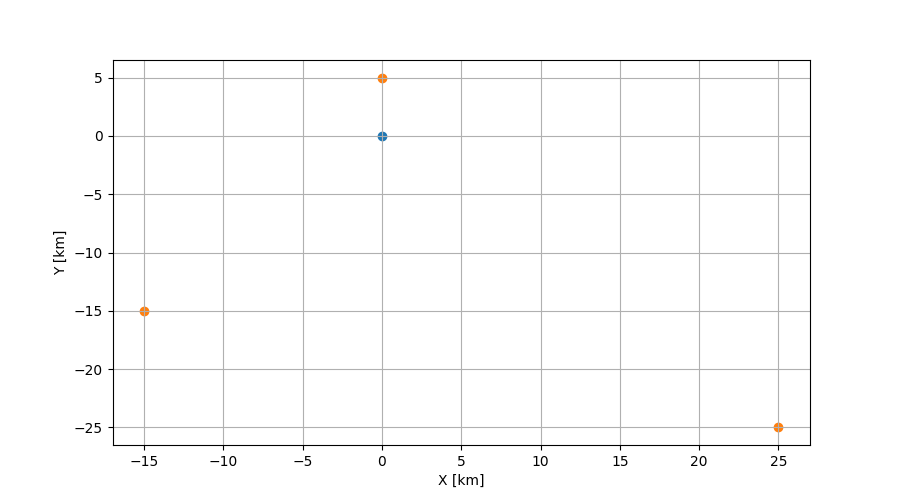

In [120]:
# TX Co-ordinates (km)
tx = np.array([0, 0])

# RX Co-ordinates (km)
rx1 = np.array([0, 5])
rx2 = np.array([-15, -15])
rx3 = np.array([25, -25])

# Plot Geometry
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(tx))
ax1.scatter(*zip(*(rx1,rx2,rx3)))

# Labels
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.grid(True)
plt.show()

Next lets compute the distance between the transmitter and each of the recievers allowing the time of flight to be determined.

In [121]:
import pandas as pd
from numpy import linalg as LA

# Distances (m)
d1 = LA.norm(tx-rx1)*1e3
d2 = LA.norm(tx-rx2)*1e3
d3 = LA.norm(tx-rx3)*1e3

# Times (s)
t1 = d1/(3e8)
t2 = d2/(3e8)
t3 = d3/(3e8)

# Num. Samples
n1 = t1/T
n2 = t2/T
n3 = t3/T

# TDOA
t2_1 = t2-t1
t3_1 = t3-t1
n2_1 = t2_1/T
n3_1 = t3_1/T

# Plot Table
data = [[d1,d2,d3], [t1*1e9,t2*1e9,t3*1e9], [n1,n2,n3], [0, t2_1*1e9, t3_1*1e9], [0, n2_1, n3_1]]
headings = ['Distance (m)','TOF (ns)', 'Samples', 'TDOA (ns)', 'Samples']
df = pd.DataFrame(np.transpose(data), ['RX1', 'RX2', 'RX3'], headings)
df.round(2)

,Distance (m),TOF (ns),Samples,TDOA (ns),Samples
RX1,5000.00,16666.67,512.00,0.00,0.00
RX2,21213.20,70710.68,2172.23,54044.01,1660.23
RX3,35355.34,117851.13,3620.39,101184.46,3108.39


## Time Delay

Lets visualise the time delay between the recieved signals. For now we will just round the TOF to be an integer multiple of the sampling period, which is equal to about 32.55 ns. This will give a conservative estimate of the system performance in return for increased simplicity of the model. Because x(t) is continious we can simply wrap the signal around.

<IPython.core.display.Javascript object>


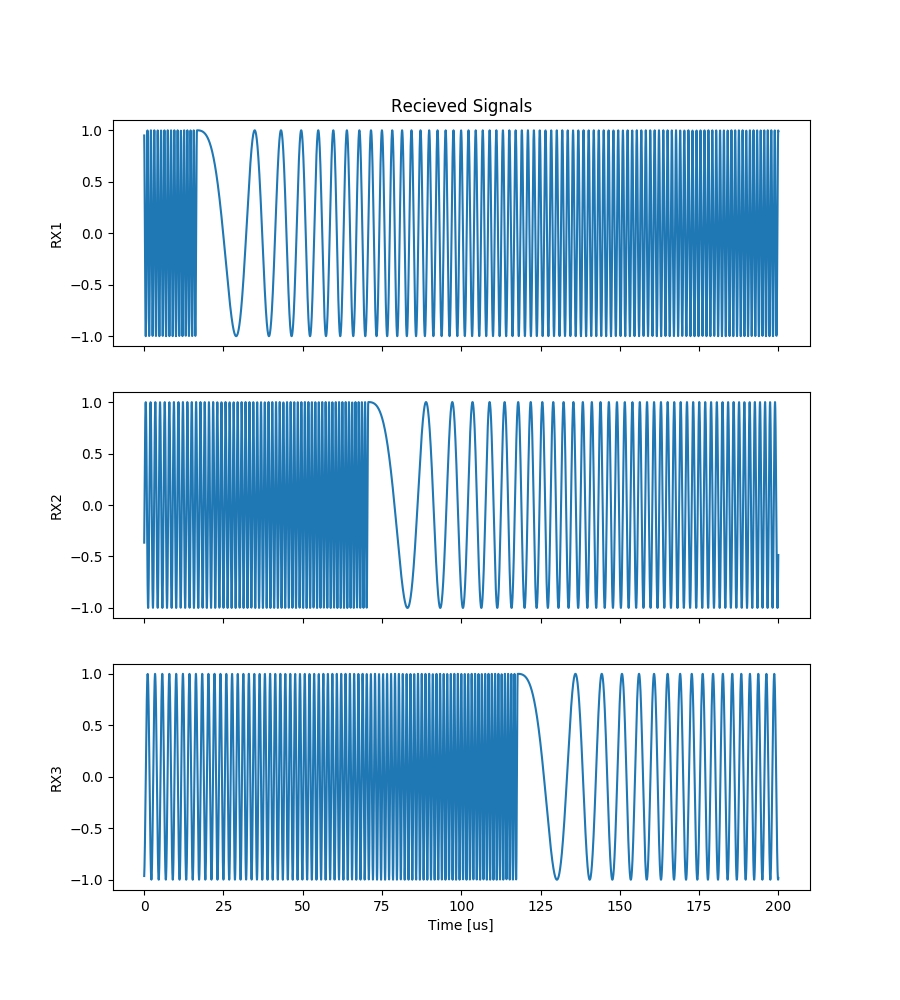

In [122]:
# Generate Recieved Signals
rx1_signal = np.roll(x, int(np.round(n1)))
rx2_signal = np.roll(x, int(np.round(n2)))
rx3_signal = np.roll(x, int(np.round(n3)))


# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, sharex=True, figsize=(9, 10))
axarr[0].plot(t*1e6, rx1_signal)
axarr[1].plot(t*1e6, rx2_signal)
axarr[2].plot(t*1e6, rx3_signal)

# Labels
axarr[0].set_title('Recieved Signals')
axarr[0].set_ylabel('RX1')
axarr[1].set_ylabel('RX2')
axarr[2].set_ylabel('RX3')
axarr[2].set_xlabel('Time [us]')

plt.show()

## Link Budget

In order to compute the power of the recieved signal we must formulate a link budget.

In [123]:
# TX Power
tx_power_mw = 500
tx_power_dbm = 10*np.log10(tx_power_mw)

# TX Gain/Loss
tx_gain = 0  # dB
tx_loss = 3  # dB

# RX Gain/Loss
rx_gain = 16 # dB
rx_loss = 3  # dB

# FSPL in dB at 2.4GHz
f = 2.4e9
fspl1 = 20*np.log10(f) + 20*np.log10(d1) - 147.55
fspl2 = 20*np.log10(f) + 20*np.log10(d2) - 147.55
fspl3 = 20*np.log10(f) + 20*np.log10(d3) - 147.55

# RX Power in dBm
rx_power_1_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl1
rx_power_2_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl2
rx_power_3_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl3

# Link Budget Breakdown
lb = [[tx_power_dbm, tx_power_dbm, tx_power_dbm],
      [tx_gain, tx_gain, tx_gain],
      [tx_loss, tx_loss, tx_loss],
      [fspl1, fspl2, fspl3],
      [rx_gain, rx_gain, rx_gain],
      [rx_loss, rx_loss, rx_loss],
      [rx_power_1_dBm, rx_power_2_dBm, rx_power_3_dBm]]

# Row Labels
labels = ['TX Power (dBm)', 'TX Gain (dB)', 'TX Loss (dB)', 'FSPL (dB)', 'RX Gain (dB)', 
          'RX Loss (dB)', 'RX Power (dBm)']
df = pd.DataFrame(lb, labels, ['RX1', 'RX2', 'RX3'])
df.round(0)

,RX1,RX2,RX3
TX Power (dBm),27.0,27.0,27.0
TX Gain (dB),0.0,0.0,0.0
TX Loss (dB),3.0,3.0,3.0
FSPL (dB),114.0,127.0,131.0
RX Gain (dB),16.0,16.0,16.0
RX Loss (dB),3.0,3.0,3.0
RX Power (dBm),-77.0,-90.0,-94.0


# Recieved Signal

We will now model the process of recieveing the signal with the SDR. There are two main sources of noise - thermal noise and quantisation noise. Both of these depend on the recieved signal strength.

## Thermal Noise
In order to simplify analysis we will make three assumtions:

1. Only the antenna and LNA/TIA/PGA contribute noise to the signal. 

2. We will assume that the antenna is lossless, and therefore it does not generate noise itself.

3. We will assume that the entire beam sees an object of constant temperature.

Nyquist tells us that the noise power due to thermal fluctuations in a resistor at temperature $T$ is given by the following relationship.

\begin{equation*}
N_{0} = kT \Delta f
\end{equation*}

In our reciever, based on the above assumptions, the antenna behaves like a resistor at a temperature equal to that of the body which the beam is pointed at. For example the night sky has a temperature of around 4K. The performance will be worst when the side lobes of the radiation pattern can see the horizon. For that reason we will take the antenna noise temperature to be $T_{A}=290\text{K}$, which is the temperature of the earth.

The thermal noise picked up by the antenna will be amplified by the SDR's front end. The datasheet for the LMS7002M says that the noise figure for the reciever is at worst 3.5dB across the entire operating range. Therefore the SNR will decrease by 3.5dB as the signal moves from the antenna to the ADC. 

In [124]:
# Parameters
Ta = 290
B = fs/2

# Antenna Noise Power Calculation
N0_mw = (1.38e-23*Ta*B)*1e3
N0_dBm = 10*np.log10(N0_mw)

print('Antenna Noise Power =', N0_dBm.round(), 'dBm')

Antenna Noise Power = -102.0 dBm


With the antenna noise power known we are now able to compute the signal to noise ratio at the input to the LNA for each of the recievers. By subtracting 3.5dB we can then find the SNR at the input to the ADC.

In [125]:
# Compute SNR
snr1_dB = rx_power_1_dBm - N0_dBm - 3.5
snr2_dB = rx_power_2_dBm - N0_dBm - 3.5
snr3_dB = rx_power_3_dBm - N0_dBm - 3.5

# Plot Table
snr_dB = [snr1_dB, snr2_dB, snr3_dB]
df3 = pd.DataFrame(np.transpose(snr_dB), ['RX1', 'RX2', 'RX3'], ['SNR (dB)'])
df3.round()

,SNR (dB)
RX1,22.0
RX2,9.0
RX3,5.0


Noise will be added to the recieved signals using the following procedure. Firstly the power of the recieved signal will be calculated using:

\begin{equation*}
P_{\text{sig}} = \frac{1}{N}\sum_{i=1}^{N} x_{i}^{2}
\end{equation*}

The noise terms will be generated i.i.d according to $n_i \sim \mathcal{N}(0,\,\sigma_{n}^{2})\ $. The power of the noise signal is given by:

\begin{equation*}
P_{\text{n}} = \frac{1}{N}\sum_{j=1}^{N} \mathbb{E}(n_{j}^{2}) = \sigma_{n}^{2}
\end{equation*}

Using the SNR, $\sigma_{n}^{2}$ can be found and the noise can then be generated.

\begin{equation*}
\sigma_{n}^{2} = P_{\text{sig}} \times 10^{-\text{SNR}/10}
\end{equation*}


In [126]:
# Calculate Power of Signal
sig_power = np.mean(np.square(x))

# Calculate Power of Noise
noise_power_1 = sig_power*np.power(10, -snr1_dB/10)
noise_power_2 = sig_power*np.power(10, -snr2_dB/10)
noise_power_3 = sig_power*np.power(10, -snr3_dB/10)

# Generate Noise Samples
noise_1 = np.random.normal(0, noise_power_1, np.size(x))
noise_2 = np.random.normal(0, noise_power_2, np.size(x))
noise_3 = np.random.normal(0, noise_power_3, np.size(x))

# Generate Recieved Signals
rx1_signal_noise = rx1_signal + noise_1
rx2_signal_noise = rx2_signal + noise_3
rx3_signal_noise = rx3_signal + noise_3

## Quantisation Noise
Whilst the SNR of the signal is correct, its amplitude is normalised. Thus to model the sampling process of the ADC we must first work out the abolute amplitude of the signal at its input. The LNA/TIA/PGA combination in the SDR has a total gain of +60dB. Thus if we take the recieved signal power from the link budget and add 60dB we should then be able to estimate the peak voltage of the signal at the input to the ADC. 

In [127]:
# Calculate Power of Signal in mW
rx1_power_mw = np.power(10.0, 0.1*(rx_power_1_dBm+60))
rx2_power_mw = np.power(10.0, 0.1*(rx_power_2_dBm+60))
rx3_power_mw = np.power(10.0, 0.1*(rx_power_3_dBm+60))

# Calculate Peak Voltage assuming P = 0.5xVo^2
rx1_vpeak = np.power(rx1_power_mw/500, 0.5)
rx2_vpeak = np.power(rx2_power_mw/500, 0.5)
rx3_vpeak = np.power(rx3_power_mw/500, 0.5)

# LNA/TIA/PGA Output
rx1_signal_adc_in = rx1_signal_noise*rx1_vpeak
rx2_signal_adc_in = rx2_signal_noise*rx2_vpeak
rx3_signal_adc_in = rx3_signal_noise*rx3_vpeak

Next we can quantise the signal. The 12-bit ADC has the range -2047 to 2048, and the input voltage range is 0v to 1v. We therfore want to map +0.5v to 2048 and -0.5v to -2047. Hence if we multiply the signal by 4096 we can convert from volts to units. Rounding to the nearest integer will then give us the quantisation noise. 

<IPython.core.display.Javascript object>


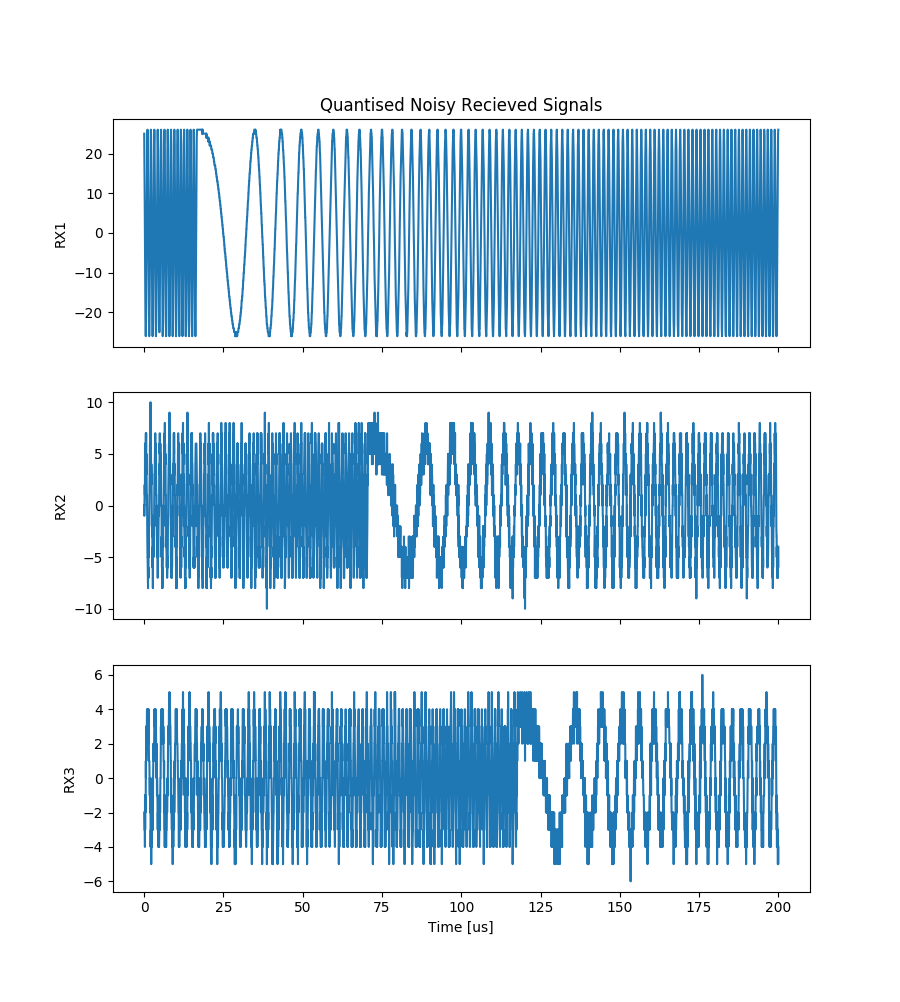

In [128]:
# Quantise the Signal
rx1_signal_adc_out = np.round(rx1_signal_adc_in*4096)
rx2_signal_adc_out = np.round(rx2_signal_adc_in*4096)
rx3_signal_adc_out = np.round(rx3_signal_adc_in*4096)


# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, sharex=True, figsize=(9, 10))
axarr[0].plot(t*1e6, rx1_signal_adc_out)
axarr[1].plot(t*1e6, rx2_signal_adc_out)
axarr[2].plot(t*1e6, rx3_signal_adc_out)

# Labels
axarr[0].set_title('Quantised Noisy Recieved Signals')
axarr[0].set_ylabel('RX1')
axarr[1].set_ylabel('RX2')
axarr[2].set_ylabel('RX3')
axarr[2].set_xlabel('Time [us]')
plt.show()

# TDOA Estimation
Now we have an estimate of what the recieved signal will look like, we can try and work out the TDOA. In reality we also have the problem of syncronising each of the recievers. This will be done using the PPS output of a GPS module. The SDR will report the sample index that correspods to the 0 -> 1 transition of this signal. Analysis has shown that using this method we should be able to align the streams to $\pm$1 sample.

In [135]:
# Cross-Correlate Signals
c21 = signal.correlate(np.asarray(rx1_signal_adc_out), np.asarray(rx2_signal_adc_out), 'same')
c31 = signal.correlate(np.asarray(rx1_signal_adc_out), np.asarray(rx3_signal_adc_out), 'same')
c_tdoa = [np.argmax(c21), np.argmax(c31)]

<IPython.core.display.Javascript object>


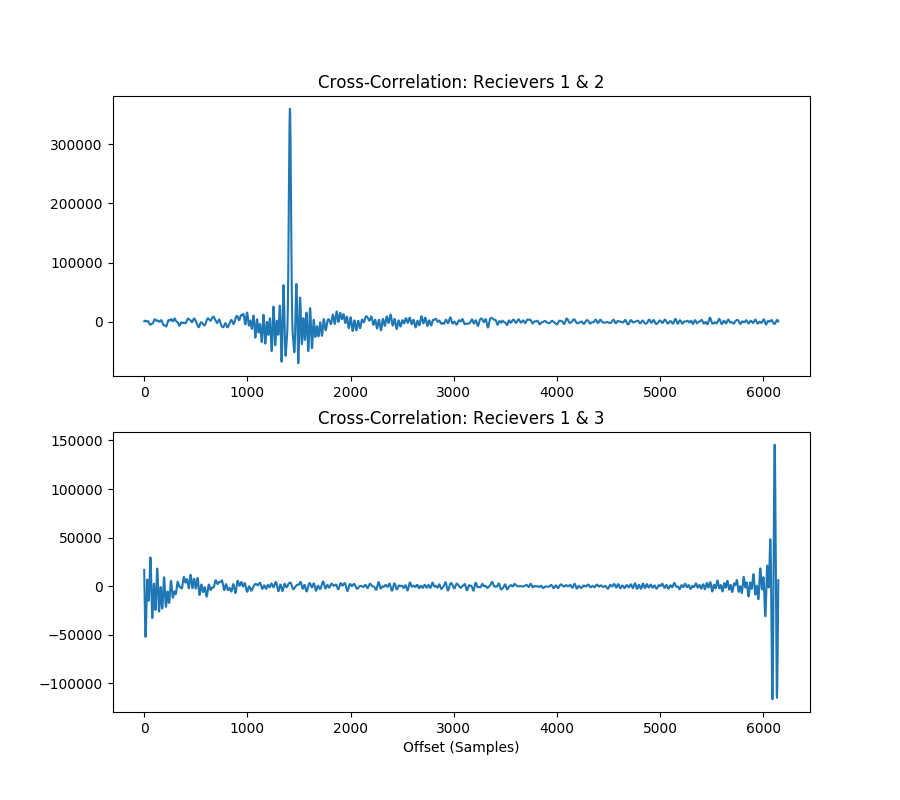

In [136]:
# Plot Signals Sharing x-axis
f, axarr = plt.subplots(2, figsize=(9, 8))
axarr[0].plot(c21)
axarr[1].plot(c31)

# Display Graphs
axarr[0].set_title('Cross-Correlation: Recievers 1 & 2')
axarr[1].set_title('Cross-Correlation: Recievers 1 & 3')
axarr[1].set_xlabel('Offset (Samples)')
plt.show()

Finally lets extract the measured TDOA and compare against the theoretical value calculated earlier.

In [137]:
# Convert Correlation to Time of Flight
tdoa = np.zeros(2)
for i in range (0,2):
    if(c_tdoa[i]<3072):
        tdoa[i]=3072-c_tdoa[i]
    else:
        tdoa[i]=6145-(c_tdoa[i]-3072)

In [138]:
# Plot Table
tdoa_data = [[t1*1e9,t2*1e9,t3*1e9], [0, t2_1*1e9, t3_1*1e9], [0, n2_1, n3_1], [0, tdoa[0], tdoa[1]]]
headings = ['TOF (ns)', 'TDOA (ns)', 'Samples', 'Measured']
df2 = pd.DataFrame(np.transpose(tdoa_data), ['RX1', 'RX2', 'RX3'], headings)
df2.round(2)

,TOF (ns),TDOA (ns),Samples,Measured
RX1,16666.67,0.00,0.00,0.0
RX2,70710.68,54044.01,1660.23,1660.0
RX3,117851.13,101184.46,3108.39,3108.0


# TOF Estimation


We can also cross-correlate the transmitted signal with each of the recieved signals in order to estimate the time of flight. Lets do that and compare with the calculated values above. 

<IPython.core.display.Javascript object>


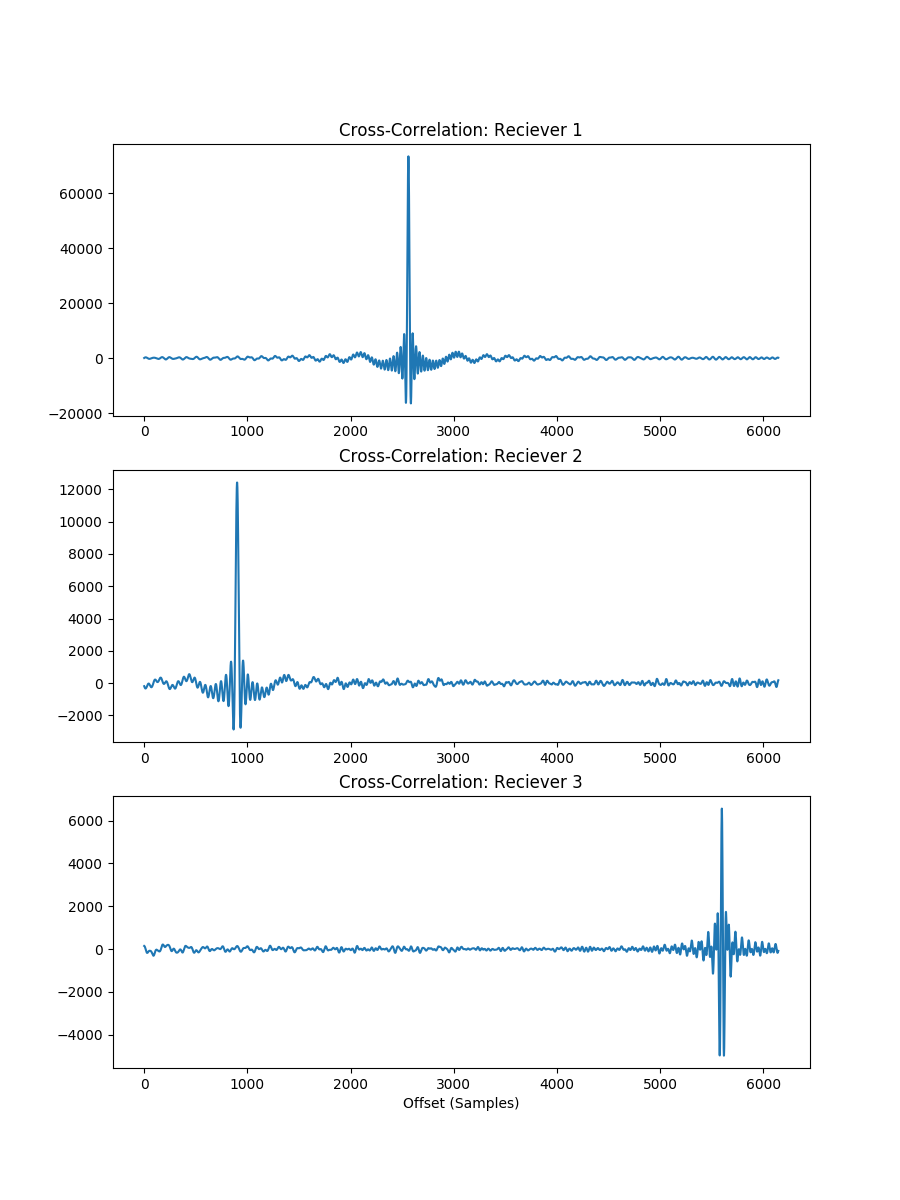

In [139]:
# Compute Cross-Correlation
c1 = signal.correlate(np.asarray(x), np.asarray(rx1_signal_adc_out), 'same')
c2 = signal.correlate(np.asarray(x), np.asarray(rx2_signal_adc_out), 'same')
c3 = signal.correlate(np.asarray(x), np.asarray(rx3_signal_adc_out), 'same')

# Index of Maximum of Cross Correlation
c_tof = [np.argmax(c1),np.argmax(c2),np.argmax(c3)]

# Convert Correlation to Time of Flight
tof = np.zeros(3)
for i in range (0,3):
    if(c_tof[i]<3072):
        tof[i]=3072-c_tof[i]
    else:
        tof[i]=6145-(c_tof[i]-3072)

# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, figsize=(9, 12))
axarr[0].plot(c1)
axarr[1].plot(c2)
axarr[2].plot(c3)

# Display Graphs
axarr[0].set_title('Cross-Correlation: Reciever 1')
axarr[1].set_title('Cross-Correlation: Reciever 2')
axarr[2].set_title('Cross-Correlation: Reciever 3')
axarr[2].set_xlabel('Offset (Samples)')
plt.show()

In [140]:
# Plot Table
tof_data = [[t1*1e9,t2*1e9,t3*1e9], [n1,n2,n3], tof]
headings = ['TOF (ns)', 'Samples', 'Measured']
df3 = pd.DataFrame(np.transpose(tof_data), ['RX1', 'RX2', 'RX3'], headings)
df3.round(2)

,TOF (ns),Samples,Measured
RX1,16666.67,512.00,512.0
RX2,70710.68,2172.23,2172.0
RX3,117851.13,3620.39,3620.0
